In [40]:
# Tải dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hoantainson/dataset-weather-vit-nam-trong-1-nm-li")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\ADMIN\.cache\kagglehub\datasets\hoantainson\dataset-weather-vit-nam-trong-1-nm-li\versions\24


# 1. Libraries

In [41]:
# Thư viện cần dùng
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore") # Lọc warning để có output đẹp

# 2.1. Data Collection

## 1. What subject is your data about?
* **Topic & Domain:** Dữ liệu thời tiết hàng ngày (Daily Weather Data) tại các tỉnh thành của Việt Nam.
* **Real-world context:** Bộ dữ liệu phản ánh điều kiện khí tượng thực tế (nhiệt độ, độ ẩm, lượng mưa, tốc độ gió, chỉ số UV, v.v.) tại 63 tỉnh thành trên khắp Việt Nam. Thông tin này đóng vai trò quan trọng trong việc dự báo thời tiết, lên kế hoạch nông nghiệp, du lịch và các hoạt động đời sống hàng ngày.

## 2. What is the source of your data?
* **Platform:** Kaggle.
* **URL:** [Dataset Weather Viet Nam trong 1 nam lai](https://www.kaggle.com/datasets/hoantainson/dataset-weather-vit-nam-trong-1-nm-li)
* **Author:** Hoàng Thanh Sơn - Sinh viên năm 3 tại Đại học Công nghệ Thông tin (UIT) (Kaggle user: `hoantainson`).
* **Publication Date:** Được cập nhật khoảng 6 tháng trước (dựa trên metadata hiện tại).
* **Collection Date:** Từ `2024-04-21` đến `2025-06-04`.

## 3. Is this data licensed for your use?
* **License:** MIT License.
* **Educational Use Permission:** **Có**. Giấy phép MIT là mã nguồn mở, cho phép sử dụng, sao chép, sửa đổi và phân phối miễn phí, hoàn toàn phù hợp cho mục đích giáo dục và nghiên cứu.

> **MIT License Detail:**
>
> Copyright (c) 2013 Mark Otto.  
> Copyright (c) 2017 Andrew Fong.
>
> Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software...
>
> *THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND...*

## 4. How was this data collected?
* **Collection Method:** Gọi API từ [weatherapi.com](https://www.weatherapi.com/) – nguồn dữ liệu thời tiết lịch sử và dự báo uy tín.
* **Quy trình xử lý:**
    1.  **Retrieval:** Dùng API truy xuất dữ liệu thô (nhiệt độ, lượng mưa...) cho từng tỉnh.
    2.  **Exploratory Data Analysis (EDA):** Kiểm tra cấu trúc, tìm mẫu hình (patterns) và phát hiện điểm bất thường/giá trị thiếu.
    3.  **Data Cleaning:** Xử lý sự không nhất quán để đảm bảo độ chính xác.
    4.  **Compilation:** Tổng hợp dữ liệu sạch thành định dạng `.csv`.
* **Target Population:** 63 tỉnh/thành phố tại Việt Nam.
* **Time Period:** 410 ngày (Từ `2024-04-21` đến `2025-06-04`).
* **Limitations:** Do tổng hợp từ bên thứ ba (API), có thể tồn tại sai số đo đạc từ trạm gốc hoặc giá trị bị thiếu (missing values) khi request.

## 5. Why did you choose this dataset?
* **Interest (Lý do chọn đề tài):**
    * Tính cấp thiết: Việt Nam đang đối mặt với thời tiết cực đoan (bão, lũ) gây thiệt hại lớn về người và tài sản.
    * Mục tiêu: Phân tích dữ liệu 63 tỉnh thành giúp hiểu quy luật khí tượng, hỗ trợ cảnh báo sớm và giảm nhẹ thiên tai.
* **Potential Insights:** Bộ dữ liệu đủ phức tạp để thực hiện các mô hình Machine Learning:
    * **Regression:** Dự báo nhiệt độ trung bình ngày hôm sau dựa trên dữ liệu lịch sử.
    * **Classification:** Dự đoán khả năng có mưa (`day.daily_will_it_rain`) dựa trên độ ẩm và áp suất.

In [42]:
csv_file = os.path.join(path, "df_weather.csv")

# Đọc dữ liệu
df = pd.read_csv(csv_file)

column_groups = {
    
    "📍 Thông tin Địa lý": [
        "location.name",      # ✅ GIỮ - Tên tỉnh/thành phố
        "location.region",    # ✅ GIỮ - Vùng miền (quan trọng cho phân tích)
        "location.terrain",   # ✅ GIỮ - Địa hình (đồng bằng, miền núi, ven biển)
        "location.country",   # ⚠️  XÓA - Tất cả đều là Vietnam
        "location.lat",       # ✅ GIỮ - Vĩ độ (dùng cho visualization map)
        "location.lon",       # ✅ GIỮ - Kinh độ (dùng cho visualization map)
    ],
    
    "📅 Thông tin Thời gian": [
        "date",              # ✅ GIỮ + CHUYỂN ĐỔI sang datetime
        "date_epoch",        # ⚠️  XÓA - Dư thừa (có thể tạo lại từ date)
    ],
    
    "🌡️  Nhiệt độ (Temperature)": [
        "day.maxtemp_c",     # ✅ GIỮ - Nhiệt độ max (Celsius)
        "day.mintemp_c",     # ✅ GIỮ - Nhiệt độ min (Celsius)
        "day.avgtemp_c",     # ✅ GIỮ - Nhiệt độ trung bình (Celsius)
        "day.maxtemp_f",     # ⚠️  XÓA - Dư thừa (Fahrenheit)
        "day.mintemp_f",     # ⚠️  XÓA - Dư thừa
        "day.avgtemp_f",     # ⚠️  XÓA - Dư thừa
    ],
    
    "💨 Gió & Mưa (Wind & Precipitation)": [
        "day.maxwind_kph",     # ✅ GIỮ - Tốc độ gió max (km/h)
        "day.maxwind_mph",     # ⚠️  XÓA - Dư thừa (mph)
        "day.totalprecip_mm",  # ✅ GIỮ - Lượng mưa (mm)
        "day.totalprecip_in",  # ⚠️  XÓA - Dư thừa (inches)
        "day.totalsnow_cm",    # ⚠️  XÓA - Việt Nam không có tuyết
    ],
    
    "👁️  Tầm nhìn & Độ ẩm (Visibility & Humidity)": [
        "day.avgvis_km",       # ✅ GIỮ - Tầm nhìn (km)
        "day.avgvis_miles",    # ⚠️  XÓA - Dư thừa (miles)
        "day.avghumidity",     # ✅ GIỮ - Độ ẩm %
    ],
    
    "☀️ Điều kiện thời tiết (Weather Conditions)": [
        "day.daily_will_it_rain",      # ✅ GIỮ + CHUYỂN ĐỔI sang boolean
        "day.daily_chance_of_rain",    # ✅ GIỮ - Xác suất mưa %
        "day.daily_will_it_snow",      # ⚠️  XÓA - Không liên quan VN
        "day.daily_chance_of_snow",    # ⚠️  XÓA - Không liên quan VN
        "day.condition.text",          # ✅ GIỮ - Mô tả thời tiết
        "day.condition.icon",          # ⚠️  XÓA - Link icon, không cần thiết
        "day.condition.code",          # ✅ GIỮ - Mã điều kiện (có thể dùng)
        "day.uv",                      # ✅ GIỮ - Chỉ số UV
    ],
    
    "🌙 Dữ liệu Thiên văn (Astronomical)": [
        "astro.sunrise",        # ✅ GIỮ (nếu cần) - Thời gian mặt trời mọc
        "astro.sunset",         # ✅ GIỮ (nếu cần) - Thời gian mặt trời lặn
        "astro.moonrise",       # ⚠️  CÂN NHẮC - Ít dùng trong phân tích
        "astro.moonset",        # ⚠️  CÂN NHẮC - Ít dùng trong phân tích
        "astro.moon_phase",     # ⚠️  CÂN NHẮC - Ít dùng trong phân tích
        "astro.moon_illumination", # ⚠️  CÂN NHẮC - Ít dùng trong phân tích
    ],
}

BƯỚC 1: XÓA CÁC CỘT DƯ THỪA
✂️  Xóa các cột:
   - location.country (tất cả là Vietnam)
   - date_epoch (tính lại được từ date)
   - Các cột Fahrenheit: maxtemp_f, mintemp_f, avgtemp_f
   - Các cột mph/miles/inches: maxwind_mph, avgvis_miles, totalprecip_in
   - Các cột về tuyết: totalsnow_cm, daily_will_it_snow, daily_chance_of_snow
   - day.condition.icon (link không cần thiết)
   - (Tùy chọn) Các cột thiên văn về mặt trăng nếu không dùng

BƯỚC 2: CHUYỂN ĐỔI KIỂU DỮ LIỆU
🔄 Chuyển đổi:
   - date → datetime64 (dùng pd.to_datetime)
   - location.name → category
   - location.region → category
   - location.terrain → category
   - day.condition.text → category
   - day.daily_will_it_rain → boolean (0→False, 1→True)

BƯỚC 3: XỬ LÝ DỮ LIỆU BẤT THƯỜNG
🔧 Kiểm tra và sửa:
   - Xóa/sửa hàng có maxtemp_c < mintemp_c
   - Kiểm tra nhiệt độ âm (không hợp lý ở VN)
   - Kiểm tra độ ẩm ngoài 0-100%
   - Xử lý giá trị âm trong lượng mưa (nếu có)

BƯỚC 4: TẠO CÁC CỘT MỚI (FEATURE ENGINEERING)
➕ Tạo thêm:
   - temperature_range = maxtemp_c - mintemp_c (biên độ nhiệt)
   - month, quarter, season từ cột date
   - is_rainy = totalprecip_mm > 0 (ngày có mưa)
   - rain_category = phân loại mưa (nhỏ/vừa/to)
   - temp_category = phân loại nhiệt độ (lạnh/mát/nóng)

# 2.2. Data Exploration

In [43]:
print("DATASET OVERVIEW\n")
print("Basic Information:")

num_rows = len(df)
num_cols = len(df.columns)

memory_usage_bytes = df.memory_usage(deep=True).sum()
memory_usage_mb = memory_usage_bytes / (1024 * 1024)

print(f"The dataset has {num_rows:,} rows.")
print(f"The dataset has {num_cols} columns.")
print(f"Each row represents the daily weather summary for a specific location.")
print(f"The overall size of the dataset is {memory_usage_mb:.2f} MB.")

print("\nData Integrity: ")

# 1. Check for duplicates
duplicate_count = df.duplicated().sum()

if duplicate_count > 0:
    print(f"Yes, there are {duplicate_count} duplicated rows.")
else:
    print("No, there are no duplicated rows.")

# 2. Check for empty rows
empty_rows_count = df.isnull().all(axis=1).sum()

if empty_rows_count > 0:
    print(f"No, there are {empty_rows_count} entirely empty rows.")
else:
    print("Yes, all rows are complete (no entirely empty rows).")

# Remove duplicates
if duplicate_count > 0:
    print(f"\nRemoving {duplicate_count} duplicated rows...")
    df = df.drop_duplicates()
    print(f"Duplicates removed")


DATASET OVERVIEW

Basic Information:
The dataset has 26,018 rows.
The dataset has 34 columns.
Each row represents the daily weather summary for a specific location.
The overall size of the dataset is 25.31 MB.

Data Integrity: 
Yes, there are 252 duplicated rows.
Yes, all rows are complete (no entirely empty rows).

Removing 252 duplicated rows...
Duplicates removed


**Decision: Duplicates should be removed**

**Justification:**

1. **Data Accuracy**: In this weather dataset, each row corresponds to the specific weather conditions of a unique location on a unique date. Having duplicates implies redundant or erroneous data collection.

2. **Statistical Validity**: Keeping duplicates would artificially inflate the sample size, leading to biased statistical metrics.

3. **Model Performance**: If used for machine learning, duplicates can cause data leakage.

## 2.2. Data Exploration - Column Inventory

**1. What is the meaning/definition of each column?**

Dựa trên thông tin của bộ dữ liệu, dưới đây là định nghĩa chi tiết cho từng cột:

| **Nhóm** | **Tên Cột** | **Định nghĩa** |
| :--- | :--- | :--- |
| **Thông tin Địa điểm** | `location.name` | Tên thành phố/tỉnh (ví dụ: An Giang, Hà Nội). |
| | `location.region` | Vùng miền hành chính (ví dụ: Đồng Bằng Sông Cửu Long). |
| | `location.terrain` | Loại địa hình của địa điểm (ví dụ: đồng bằng, ven biển, miền núi). |
| | `location.country` | Tên quốc gia (Vietnam). |
| | `location.lat` | Tọa độ Vĩ độ của địa điểm. |
| | `location.lon` | Tọa độ Kinh độ của địa điểm. |
| **Thông tin Thời gian** | `date` | Ngày quan sát (định dạng YYYY-MM-DD). |
| | `date_epoch` | Ngày quan sát dưới định dạng Unix epoch. |
| **Nhiệt độ** | `day.maxtemp_c` | Nhiệt độ cao nhất trong ngày (độ C). |
| | `day.maxtemp_f` | Nhiệt độ cao nhất trong ngày (độ F). |
| | `day.mintemp_c` | Nhiệt độ thấp nhất trong ngày (độ C). |
| | `day.mintemp_f` | Nhiệt độ thấp nhất trong ngày (độ F). |
| | `day.avgtemp_c` | Nhiệt độ trung bình trong ngày (độ C). |
| | `day.avgtemp_f` | Nhiệt độ trung bình trong ngày (độ F). |
| **Gió & Lượng mưa** | `day.maxwind_kph` | Tốc độ gió tối đa tính bằng km/h. |
| | `day.maxwind_mph` | Tốc độ gió tối đa tính bằng dặm/h (mph). |
| | `day.totalprecip_mm` | Tổng lượng mưa tính bằng milimet (mm). |
| | `day.totalprecip_in` | Tổng lượng mưa tính bằng inch. |
| | `day.totalsnow_cm` | Tổng lượng tuyết rơi tính bằng centimet (cm). |
| **Tầm nhìn & Độ ẩm** | `day.avgvis_km` | Tầm nhìn xa trung bình tính bằng km. |
| | `day.avgvis_miles` | Tầm nhìn xa trung bình tính bằng dặm (miles). |
| | `day.avghumidity` | Độ ẩm trung bình (%). |
| **Điều kiện Thời tiết** | `day.condition.text` | Mô tả thời tiết bằng văn bản (ví dụ: Nắng, Có thể có mưa rải rác). |
| | `day.condition.icon` | Đường dẫn (URL) đến hình ảnh biểu tượng thời tiết. |
| | `day.condition.code` | Mã định danh duy nhất đại diện cho điều kiện thời tiết. |
| | `day.daily_will_it_rain` | Giá trị Boolean chỉ báo sẽ có mưa hay không (1 = Có, 0 = Không). |
| | `day.daily_chance_of_rain` | Xác suất/Khả năng có mưa tính theo phần trăm (%). |
| | `day.uv` | Chỉ số tia cực tím (UV Index) hàng ngày. |
| **Dữ liệu Thiên văn** | `astro.sunrise` | Thời gian mặt trời mọc. |
| | `astro.sunset` | Thời gian mặt trời lặn. |
| | `astro.moonrise` | Thời gian trăng mọc. |
| | `astro.moonset` | Thời gian trăng lặn. |
| | `astro.moon_phase` | Chu kỳ (pha) của mặt trăng (ví dụ: Trăng khuyết đầu tháng). |
| | `astro.moon_illumination` | Tỷ lệ phần trăm độ sáng của mặt trăng. |


**2. Which columns are relevant to potential analysis?**

# 2. Những cột dữ liệu nào phù hợp cho việc phân tích tiềm năng?

Các cột sau đây đã được lựa chọn cho quá trình phân tích:

## Thông tin Địa lý
- `location.name`
- `location.region`
- `location.terrain`
- `location.lat`
- `location.lon`

## Thông tin Thời gian
- `date`

## Nhiệt độ
- `day.maxtemp_c`
- `day.mintemp_c`
- `day.avgtemp_c`

## Gió & Mưa
- `day.maxwind_kph`
- `day.totalprecip_mm`

## Tầm nhìn & Độ ẩm
- `day.avgvis_km`
- `day.avghumidity`

## Điều kiện thời tiết
- `day.daily_will_it_rain`
- `day.daily_chance_of_rain`
- `day.condition.text`
- `day.condition.code`
- `day.uv`

## Dữ liệu Thiên văn
- `astro.sunrise`
- `astro.sunset`


**3. Are there any columns that should be dropped? Why?**

Nhóm quyết định loại bỏ các cột sau để đảm bảo chất lượng dữ liệu, loại bỏ sự dư thừa và tập trung vào bối cảnh khí hậu Việt Nam:

* **Đơn vị đo lường dư thừa (Không phải hệ mét):**
    * `day.maxtemp_f`, `day.mintemp_f`, `day.avgtemp_f`: Việt Nam sử dụng thang đo Celsius; độ Fahrenheit là dư thừa.
    * `day.maxwind_mph`, `day.totalprecip_in`, `day.avgvis_miles`: Việt Nam sử dụng hệ mét (km/h, mm, km); các đơn vị đo lường Anh/Mỹ là không cần thiết.

* **Ngữ cảnh không phù hợp (Tuyết):**
    * `day.totalsnow_cm`: Việt Nam là quốc gia nhiệt đới. Tuyết cực kỳ hiếm gặp và không có ý nghĩa thống kê trong bộ dữ liệu này, khiến các cột này trở nên vô nghĩa.

* **Cột chỉ có một giá trị duy nhất:**
    * `location.country`: Toàn bộ dữ liệu chỉ giới hạn trong phạm vi "Vietnam", do đó cột này không có sự biến thiên để phân tích.

* **Metadata dư thừa hoặc mang tính kỹ thuật:**
    * `date_epoch`: Dư thừa vì chúng ta đã có cột `date` ở định dạng con người có thể đọc được.
    * `day.condition.icon`: Cột này chứa đường dẫn ảnh, không hữu ích cho việc phân tích thống kê hay mô hình hóa.

* **Độ liên quan thấp (Dữ liệu Thiên văn):**
    * `astro.moonrise`, `astro.moonset`, `astro.moon_phase`, `astro.moon_illumination`: Mặc dù có sẵn, nhưng chu kỳ mặt trăng có tác động trực tiếp không đáng kể đến việc dự báo thời tiết hàng ngày so với các yếu tố mặt trời và khí quyển. Các cột này được loại bỏ để giảm số chiều dữ liệu.

In [44]:
# Danh sách các cột cần xóa (dựa trên phân tích ở trên)
columns_to_drop = [
    "location.country",         # Tất cả đều là Vietnam
    "date_epoch",               # Dư thừa
    "day.maxtemp_f",            # Dư thừa (Fahrenheit)
    "day.mintemp_f",            # Dư thừa (Fahrenheit)
    "day.avgtemp_f",            # Dư thừa (Fahrenheit)
    "day.maxwind_mph",          # Dư thừa (mph)
    "day.totalprecip_in",       # Dư thừa (inches)
    "day.totalsnow_cm",         # Không liên quan VN
    "day.avgvis_miles",         # Dư thừa (miles)
    "day.condition.icon",       # Metadata không cần thiết
    "astro.moonrise",           # Ít dùng
    "astro.moonset",            # Ít dùng
    "astro.moon_phase",         # Ít dùng
    "astro.moon_illumination",  # Ít dùng
]

# Thực hiện xóa cột
# errors='ignore' giúp tránh lỗi nếu cột không tồn tại trong dataframe
df.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')

print("Đã xóa các cột không cần thiết.")
print(f"Số lượng cột còn lại: {len(df.columns)}")
print("\nDanh sách cột hiện tại:")
print(df.columns.tolist())

Đã xóa các cột không cần thiết.
Số lượng cột còn lại: 20

Danh sách cột hiện tại:
['location.name', 'location.region', 'location.terrain', 'location.lat', 'location.lon', 'date', 'day.maxtemp_c', 'day.mintemp_c', 'day.avgtemp_c', 'day.maxwind_kph', 'day.totalprecip_mm', 'day.avgvis_km', 'day.avghumidity', 'day.daily_will_it_rain', 'day.daily_chance_of_rain', 'day.condition.text', 'day.condition.code', 'day.uv', 'astro.sunrise', 'astro.sunset']


In [45]:
print("\nData Types:")
print("The current data type of each column: ")
print(df.dtypes)

# 1. Chuyển date sang datetime64
df['date'] = pd.to_datetime(df['date'])
print("Converted 'date' from object to datetime64")

# 2. Chuyển location.name sang category
df['location.name'] = df['location.name'].astype('category')
print("Converted 'location.name' from object to category")

# 3. Chuyển location.region sang category
df['location.region'] = df['location.region'].astype('category')
print("Converted 'location.region' from object to category")

# 4. Chuyển location.terrain sang category
df['location.terrain'] = df['location.terrain'].astype('category')
print("Converted 'location.terrain' from object to category")

# 5. Chuyển day.condition.text sang category
df['day.condition.text'] = df['day.condition.text'].astype('category')
print("Converted 'day.condition.text' from object to category")

# 6. Chuyển day.daily_will_it_rain sang boolean
df['day.daily_will_it_rain'] = df['day.daily_will_it_rain'].astype('bool')
print("Converted 'day.daily_will_it_rain' from int64 to bool")

df['astro.sunrise'] = pd.to_datetime(
    df['date'].astype(str) + ' ' + df['astro.sunrise'],
    format='%Y-%m-%d %I:%M %p',
    errors='coerce'
)
print("Converted 'astro.sunrise' to datetime64")

df['astro.sunset'] = pd.to_datetime(
    df['date'].astype(str) + ' ' + df['astro.sunset'],
    format='%Y-%m-%d %I:%M %p',
    errors='coerce'
)
print("Converted 'astro.sunset' to datetime64")




Data Types:
The current data type of each column: 
location.name                object
location.region              object
location.terrain             object
location.lat                float64
location.lon                float64
date                         object
day.maxtemp_c               float64
day.mintemp_c               float64
day.avgtemp_c               float64
day.maxwind_kph             float64
day.totalprecip_mm          float64
day.avgvis_km               float64
day.avghumidity               int64
day.daily_will_it_rain        int64
day.daily_chance_of_rain      int64
day.condition.text           object
day.condition.code            int64
day.uv                      float64
astro.sunrise                object
astro.sunset                 object
dtype: object
Converted 'date' from object to datetime64
Converted 'location.name' from object to category
Converted 'location.region' from object to category
Converted 'location.terrain' from object to category
Converted 'day.c

## Data Types

**1. What is the current data type of each column?**

Dựa trên tổng quan về tập dữ liệu, các kiểu dữ liệu hiện tại như sau:

| Column Name | Current Data Type |
| :--- | :--- |
| `location.name` | `object` |
| `location.region` | `object` |
| `location.terrain` | `object` |
| `location.lat` | `float64` |
| `location.lon` | `float64` |
| `date` | `object` |
| `day.maxtemp_c` | `float64` |
| `day.mintemp_c` | `float64` |
| `day.avgtemp_c` | `float64` |
| `day.maxwind_kph` | `float64` |
| `day.totalprecip_mm` | `float64` |
| `day.avgvis_km` | `float64` |
| `day.avghumidity` | `int64` |
| `day.daily_will_it_rain` | `int64` |
| `day.daily_chance_of_rain` | `int64` |
| `day.condition.text` | `object` |
| `day.condition.code` | `int64` |
| `day.uv` | `float64` |
| `astro.sunrise` | `object` |
| `astro.sunset` | `object` |


**2. Are there columns with inappropriate data types?**

Có, dựa trên việc kiểm tra sơ bộ, nhiều cột cần được chuẩn hóa để phù hợp với việc phân tích và tối ưu hóa hiệu suất hệ thống:

* **Dữ liệu Chuỗi thời gian (`date`):** Hiện đang ở dạng chuỗi ký tự (`object`), không thể thực hiện các phép toán thời gian (như lấy tháng, năm, thứ).
* **Dữ liệu Giờ giấc (`astro.sunrise`, `astro.sunset`):** Đang là chuỗi văn bản chỉ chứa giờ (ví dụ "05:30 AM"). Chúng thiếu thông tin ngày tháng để trở thành một mốc thời gian (timestamp) hợp lệ.
* **Biến Phân loại (Categorical):** Các cột `location.name`, `location.region`, `location.terrain`, và `day.condition.text` chứa dữ liệu văn bản lặp lại nhiều lần. Lưu trữ dưới dạng `object` gây tốn bộ nhớ không cần thiết.
* **Biến Logic (`day.daily_will_it_rain`):** Đang lưu trữ dưới dạng số nguyên (`int64`: 0 và 1), trong khi bản chất của dữ liệu là nhị phân (Đúng/Sai).

**3. Which columns need type conversion?**

Dựa trên các vấn đề đã xác định, nhóm thực hiện quy trình chuyển đổi sau:

| Tên Cột | Kiểu hiện tại | Kiểu mục tiêu (Target) | Phương pháp & Lý do chuyển đổi |
| :--- | :--- | :--- | :--- |
| `date` | `object` | **`datetime64[ns]`** | Chuyển đổi để trích xuất các đặc trưng thời gian (Tháng, Năm) và lập chỉ mục (indexing). |
| `astro.sunrise` | `object` | **`datetime64[ns]`** | **Ghép với cột `date`:** Tạo thành mốc thời gian đầy đủ (Ngày + Giờ) để tính toán chính xác. |
| `astro.sunset` | `object` | **`datetime64[ns]`** | **Ghép với cột `date`:** Tạo thành mốc thời gian đầy đủ (Ngày + Giờ). |
| `location.name` | `object` | **`category`** | Tối ưu hóa bộ nhớ do các tên tỉnh/thành phố lặp lại thường xuyên. |
| `location.region` | `object` | **`category`** | Tối ưu hóa hiệu suất cho biến phân loại vùng miền. |
| `location.terrain`| `object` | **`category`** | Tối ưu hóa hiệu suất cho biến phân loại địa hình. |
| `day.condition.text`| `object` | **`category`** | Tối ưu hóa bộ nhớ vì các mô tả thời tiết (ví dụ: "Sunny") lặp lại nhiều. |
| `day.daily_will_it_rain`| `int64` | **`bool`** | Chuyển đổi 0/1 thành True/False để phản ánh đúng bản chất Boolean. |

## Numerical Columns Analysis

Analysis for: day.maxtemp_c
Mean: 29.22 | Median: 30.00 | Std: 4.92
Min: 5.70 | Max: 43.40
Skewness: -0.70 (0=Normal, >0=Right Skewed, <0=Left Skewed)
Missing Values: 0.00%
Outliers (IQR method): 440 rows (1.71%)
Reasonable Range (Expected): 16.85 to 42.05


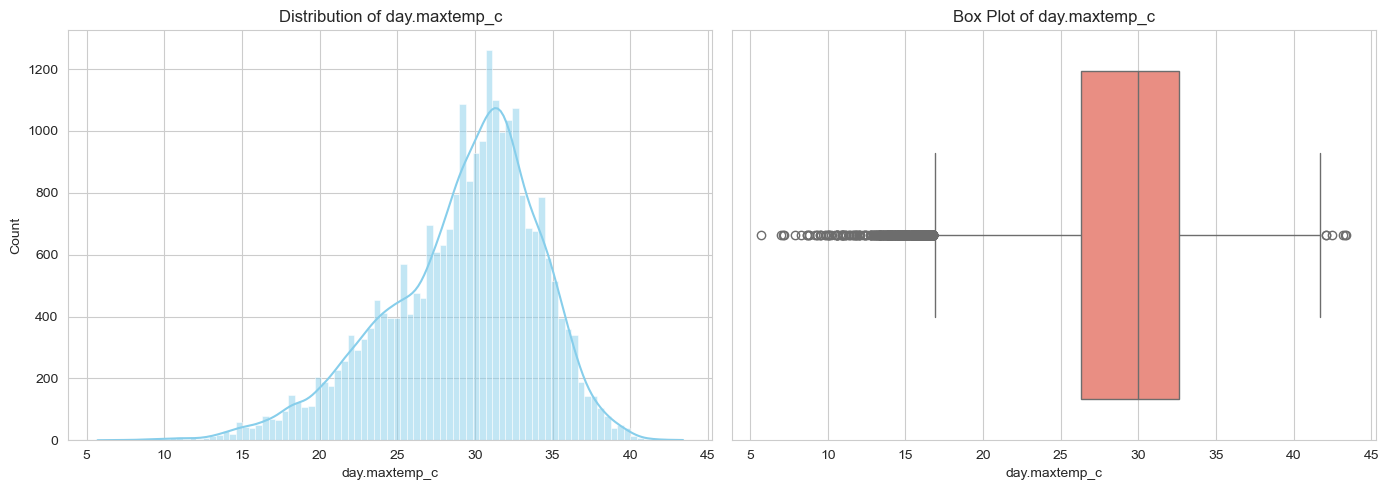



Analysis for: day.mintemp_c
Mean: 22.07 | Median: 23.50 | Std: 4.37
Min: -0.20 | Max: 30.70
Skewness: -1.14 (0=Normal, >0=Right Skewed, <0=Left Skewed)
Missing Values: 0.00%
Outliers (IQR method): 814 rows (3.16%)
Reasonable Range (Expected): 11.95 to 33.15


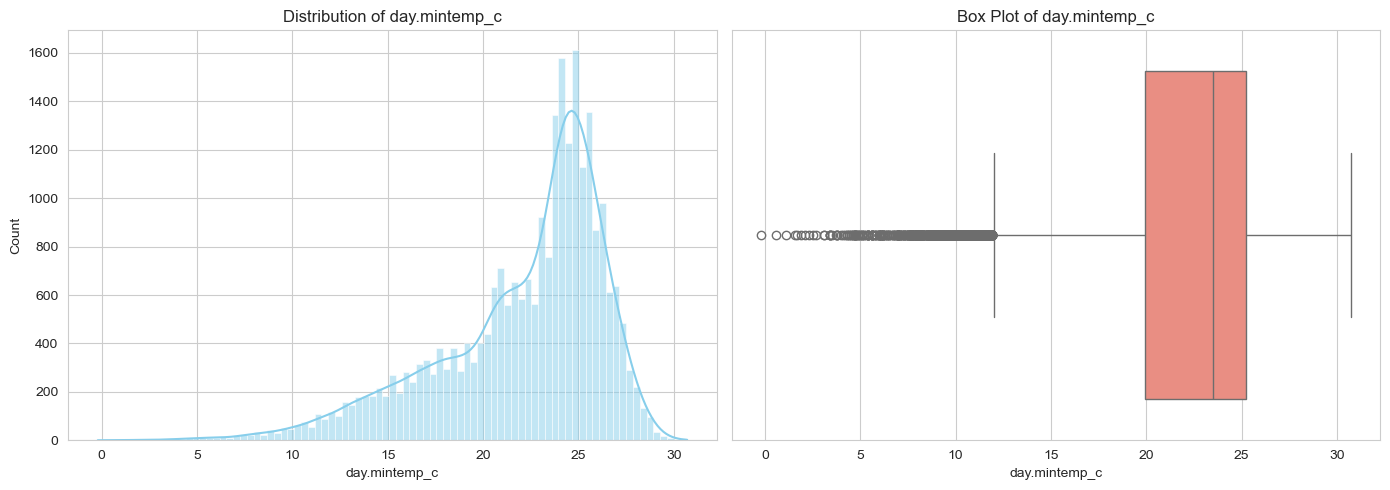



Analysis for: day.avgtemp_c
Mean: 25.06 | Median: 26.10 | Std: 4.29
Min: 3.80 | Max: 35.30
Skewness: -1.01 (0=Normal, >0=Right Skewed, <0=Left Skewed)
Missing Values: 0.00%
Outliers (IQR method): 665 rows (2.58%)
Reasonable Range (Expected): 14.85 to 36.05


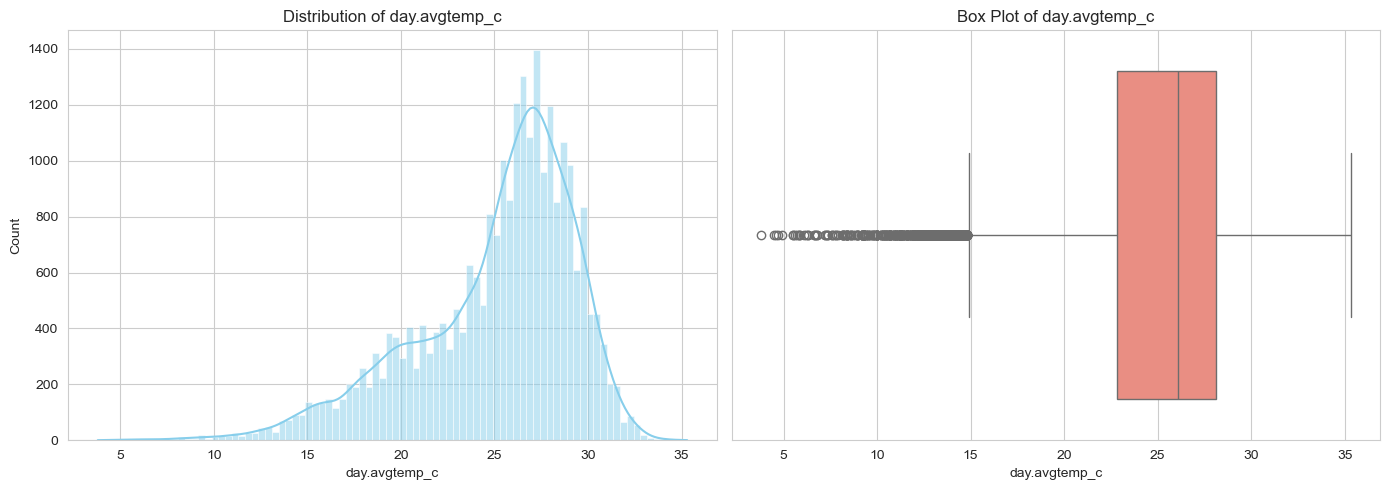

In [46]:
# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 5)

def analyze_numerical_column(df, col):
    print(f"Analysis for: {col}")
    
    # 1. Central Tendency & Distribution Stats
    desc = df[col].describe()
    skewness = df[col].skew()
    kurtosis = df[col].kurt()
    missing_pct = df[col].isnull().mean() * 100
    
    print(f"Mean: {desc['mean']:.2f} | Median: {desc['50%']:.2f} | Std: {desc['std']:.2f}")
    print(f"Min: {desc['min']:.2f} | Max: {desc['max']:.2f}")
    print(f"Skewness: {skewness:.2f} (0=Normal, >0=Right Skewed, <0=Left Skewed)")
    print(f"Missing Values: {missing_pct:.2f}%")
    
    # 2. Outlier Detection (IQR Method)
    Q1 = desc['25%']
    Q3 = desc['75%']
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outliers_pct = (outliers_count / len(df)) * 100
    
    print(f"Outliers (IQR method): {outliers_count} rows ({outliers_pct:.2f}%)")
    print(f"Reasonable Range (Expected): {lower_bound:.2f} to {upper_bound:.2f}")
    
    # 3. Visualizations
    fig, axes = plt.subplots(1, 2)
    
    # Histogram + KDE (Distribution Shape)
    sns.histplot(data=df, x=col, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Distribution of {col}')
    
    # Box Plot (Outliers)
    sns.boxplot(data=df, x=col, ax=axes[1], color='salmon')
    axes[1].set_title(f'Box Plot of {col}')
    
    plt.tight_layout()
    plt.show()
    print("\n" + "="*80 + "\n")

# Define Numerical Columns list based on the previous cleaning
# Remove 'location.lat', 'location.lon' as not providing meanings
# for distribution & range and outliers & data quality
# but can be used for meaningful questions/insights 
numerical_cols_1 = [
    'day.maxtemp_c', 'day.mintemp_c', 'day.avgtemp_c'
]

# Execute Analysis
for col in numerical_cols_1:
    analyze_numerical_column(df, col)
    

### Phân tích chi tiết: Nhóm cột Nhiệt độ (Temperature)
Dựa trên các biểu đồ histogram và boxplot, chúng ta có thể rút ra các nhận định sau về đặc điểm khí hậu trong bộ dữ liệu:

#### 1. Nhiệt độ thấp nhất trong ngày (day.mintemp_c)
##### Phân phối (Distribution):

- Hình dạng: Phân phối Lệch trái (Left Skewed) với độ lệch Skewness = -1.14.

##### Xu hướng tập trung:

- Trung bình (Mean): 22.07°C

- Trung vị (Median): 23.50°C

**Chú thích** Việc Mean < Median khẳng định xu hướng lệch trái: Đa số các ngày ở Việt Nam có nhiệt độ ban đêm khá ấm (khoảng 23-25°C), nhưng có một số ngày mùa đông rất lạnh kéo mức trung bình xuống.

##### Phạm vi & Giá trị ngoại lai (Range & Outliers):

- Min: -0.2°C. Nhận xét: Đây là giá trị rất thấp đối với khí hậu nhiệt đới. Tuy nhiên, ở các vùng núi cao phía Bắc (như Mẫu Sơn, Fansipan) vào mùa đông, nhiệt độ xuống dưới 0°C là có thật. Do đó, đây khả năng cao là dữ liệu thật (extreme values) chứ không phải lỗi nhập liệu.

- Outliers: Có 814 dòng (3.16%) bị coi là ngoại lai theo phương pháp IQR (các chấm tròn bên trái biểu đồ Box Plot). Đây chủ yếu là các ngày mùa đông lạnh (dưới 12°C).

- Max: 30.7°C (đêm mùa hè rất nóng).

#### 2. Nhiệt độ trung bình trong ngày (day.avgtemp_c)
##### Phân phối (Distribution):

- Hình dạng: Vẫn là Lệch trái (Left Skewed) (Skewness = -1.01). Đỉnh của biểu đồ (Mode) tập trung dày đặc ở khoảng 26°C - 28°C.

- Đặc điểm: Dải nhiệt độ phổ biến nhất phản ánh đúng khí hậu nóng ẩm của Việt Nam.

##### Phạm vi & Giá trị ngoại lai:

- Range: Từ 3.8°C đến 35.3°C.

- Min (3.8°C): Rất lạnh, phù hợp với các đợt rét đậm, rét hại ở miền Bắc.

- Max (35.3°C): Đây là nhiệt độ trung bình cả ngày, nên mức 35.3°C là cực kỳ nóng (nghĩa là cả ngày lẫn đêm đều hầm hập).

- Outliers: 665 dòng (2.58%). Tương tự như trên, đây là các ngày lạnh bất thường so với mặt bằng chung, không nên xóa bỏ vì chúng mang ý nghĩa dự báo thiên tai/rét đậm.

#### 3. Nhiệt độ cao nhất trong ngày (day.maxtemp_c)
- Phân phối (Distribution):

- Hình dạng: Lệch trái nhẹ (Skewness = -0.70).

- Biến động: Độ lệch chuẩn (Std) là 4.92, cao nhất trong 3 cột nhiệt độ, cho thấy nhiệt độ ban ngày giữa các mùa/vùng miền có sự chênh lệch lớn hơn so với ban đêm.

**Phạm vi & Giá trị ngoại lai**:

- Max: 43.4°C. Nhận xét: Con số này rất cao nhưng hợp lý với bối cảnh biến đổi khí hậu gần đây (năm 2023-2024, các trạm ở Tương Dương, Nghệ An đã ghi nhận kỷ lục >44°C).

- Min: 5.7°C. Một ngày mà nhiệt độ cao nhất chỉ đạt 5.7°C thì đó là ngày cực kỳ rét buốt (thường là vùng núi cao).

- Outliers: 440 dòng (1.71%). Số lượng ngoại lai ít hơn so với nhiệt độ thấp nhất, cho thấy cái nóng ở Việt Nam đồng đều hơn cái lạnh.

**Kết luận chung (Actionable Insights)**
- Chất lượng dữ liệu (Data Quality):

- Missing Values: 0.00% (Rất tốt, dữ liệu đầy đủ).

- Tính hợp lý: Các giá trị Min/Max (Min ~ -0.2°C, Max ~ 43.4°C) tuy thoạt nhìn có vẻ cực đoan nhưng hoàn toàn phù hợp với dữ liệu khí tượng thực tế của Việt Nam trải dài từ Bắc vào Nam và bao gồm cả vùng núi cao. Không có dấu hiệu lỗi nhập liệu (như 999 hay -100).

**Xử lý Outliers:**

Mặc dù phương pháp IQR đánh dấu khoảng 2-3% dữ liệu là "Outliers" (các chấm đen bên trái biểu đồ Box Plot), nhưng KHÔNG ĐƯỢC XÓA các dòng này.

Lý do: Đây là các hiện tượng thời tiết cực đoan (Rét đậm, rét hại). **Trong bài toán dự báo thời tiết, việc dự đoán đúng các ngày "ngoại lai" này quan trọng hơn nhiều so với dự đoán các ngày bình thường.**

**Feature Engineering:**

Vì phân phối bị lệch (Skewed), khi mô hình hóa (Machine Learning), ta có thể cân nhắc không cần chuẩn hóa Log (Log transform) vì độ lệch không quá lớn (chỉ quanh mức -1). Tuy nhiên, các mô hình cây quyết định (Decision Tree, Random Forest) sẽ xử lý tốt dạng dữ liệu này mà không cần biến đổi nhiều.


Analysis for: day.maxwind_kph
Mean: 15.13 | Median: 14.80 | Std: 6.10
Min: 1.40 | Max: 81.60
Skewness: 0.66 (0=Normal, >0=Right Skewed, <0=Left Skewed)
Missing Values: 0.00%
Outliers (IQR method): 293 rows (1.14%)
Reasonable Range (Expected): -1.35 to 31.05


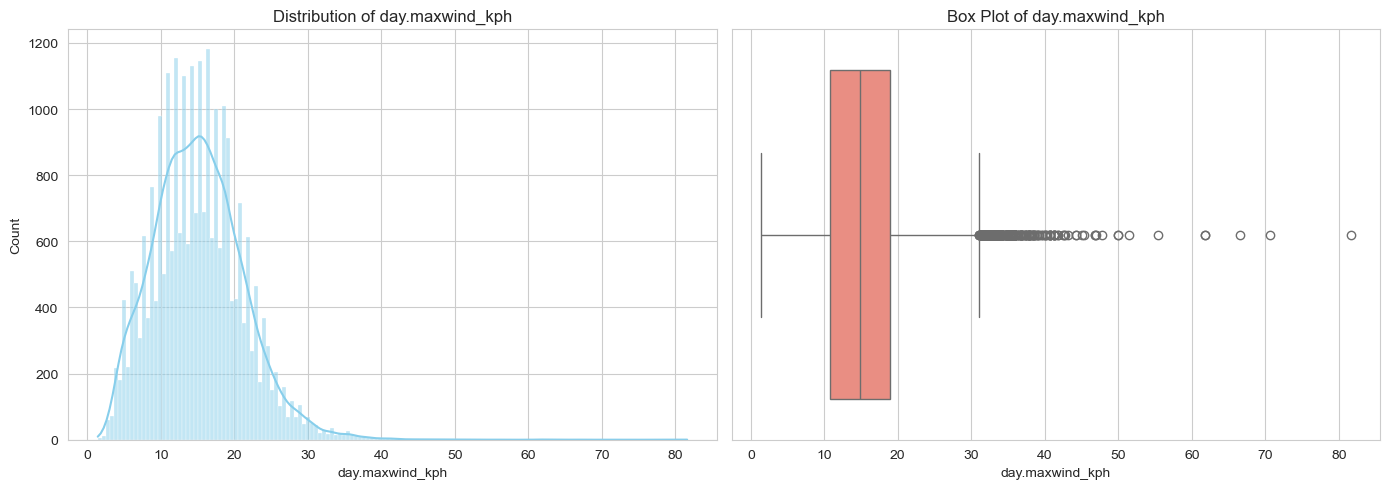



Analysis for: day.totalprecip_mm
Mean: 6.65 | Median: 1.60 | Std: 12.99
Min: 0.00 | Max: 285.20
Skewness: 6.14 (0=Normal, >0=Right Skewed, <0=Left Skewed)
Missing Values: 0.00%
Outliers (IQR method): 2187 rows (8.49%)
Reasonable Range (Expected): -12.58 to 20.98


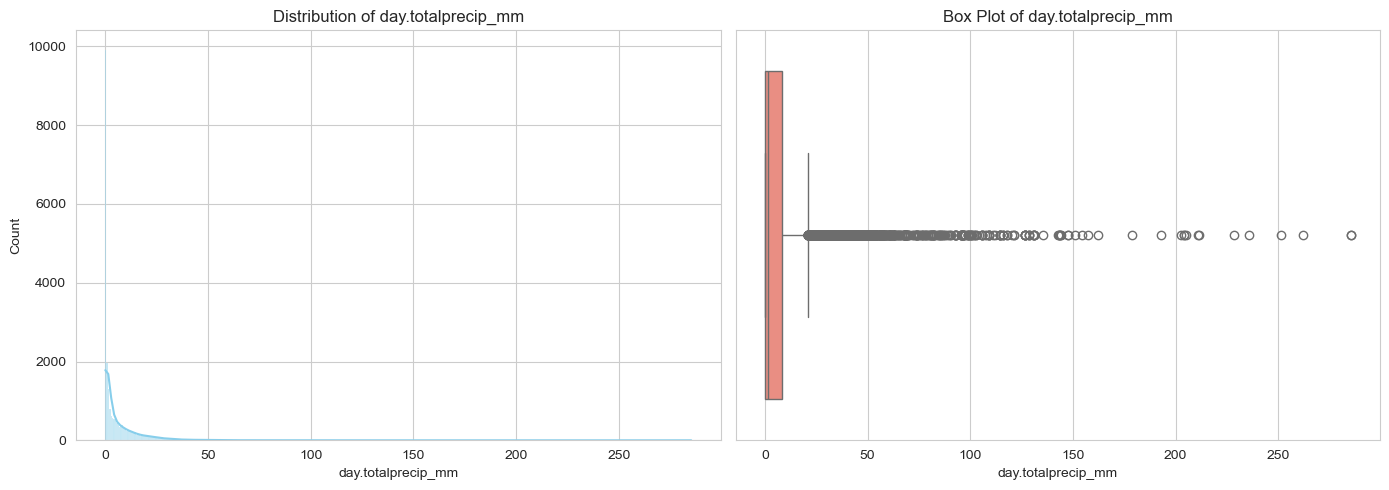

In [47]:
numerical_cols_2 = [
    'day.maxwind_kph', 'day.totalprecip_mm'
]

# Execute Analysis
for col in numerical_cols_2:
    analyze_numerical_column(df, col)
    

## Phân tích chi tiết:
#### 1. Lượng mưa trong ngày (day.totalprecip_mm)
##### Phân phối (Distribution):

- Hình dạng: Phân phối Lệch phải cực độ (Extreme Right Skewed).

- Zero-inflated (Lạm phát số 0): Biểu đồ Histogram có một cột dựng đứng rất cao ở giá trị 0. Điều này phản ánh đúng thực tế: Trong một năm, số ngày không mưa (nắng ráo) hoặc mưa không đáng kể thường chiếm đa số.

#### Phạm vi & Giá trị ngoại lai (Outliers):

- Outliers: Biểu đồ Box Plot (bên phải) hiển thị một dải dày đặc các chấm tròn (outliers) kéo dài từ khoảng 20mm đến gần 300mm.

**Giải thích: Theo thống kê thông thường (IQR), bất kỳ ngày nào mưa trên ~20mm đã bị coi là ngoại lai. Tuy nhiên, ở Việt Nam (khí hậu nhiệt đới gió mùa), các trận mưa lớn từ 50mm - 100mm, thậm chí 200mm - 300mm (trong bão) là chuyện bình thường.**

- Max: Giá trị cao nhất đạt gần 280-300mm. Đây là lượng mưa rất lớn, thường thấy trong các đợt áp thấp nhiệt đới hoặc bão đổ bộ vào miền Trung/miền Bắc.

**Kết luận: Dữ liệu này hợp lệ. Không được xử lý ngoại lai theo cách thông thường (xóa bỏ hoặc quy về giá trị trần), vì chính những giá trị "outlier" này là mục tiêu quan trọng để dự báo ngập lụt.**

#### 2. Tốc độ gió tối đa (day.maxwind_kph)
##### Phân phối (Distribution):

- Hình dạng: Phân phối khá cân đối nhưng vẫn Lệch phải nhẹ (Right Skewed) với Skewness = 0.66.

**Xu hướng tập trung:**

- Trung bình (Mean): 15.13 km/h.

- Trung vị (Median): 14.80 km/h.

**Nhận xét: Tốc độ gió trung bình khoảng 15 km/h tương đương với Gió cấp 3 (Gió nhẹ), là điều kiện thời tiết bình thường hàng ngày.**

##### Phạm vi & Giá trị ngoại lai:

- Min (1.40 km/h): Gió lặng, rất hợp lý.

- Max (81.60 km/h): Con số này tương đương Gió cấp 9 (Gió mạnh/Nhiệt đới) trên thang Beaufort. Đây là dấu hiệu rõ ràng của giông lốc mạnh hoặc ảnh hưởng của bão.

- Outliers: Có 293 dòng (1.14%) vượt ngưỡng ~31 km/h. Đây là các ngày có gió mùa Đông Bắc mạnh hoặc thời tiết xấu.

**Kết luận: Dải dữ liệu từ 1.4 đến 81.6 km/h hoàn toàn nằm trong giới hạn vật lý của thời tiết Việt Nam. Các giá trị cao là tín hiệu tốt để mô hình học được các điều kiện thời tiết nguy hiểm.**

### Tổng kết chung
- Chất lượng dữ liệu rất tốt: Không có giá trị vô lý về mặt vật lý (như mưa âm, tốc độ gió âm, hay nhiệt độ 1000 độ).

- Đặc tính chung: Hầu hết các dữ liệu khí tượng (Mưa, Gió) đều bị lệch phải (Right Skewed) do tính chất khắc nghiệt thỉnh thoảng mới xảy ra của thiên nhiên.

Chiến lược cho bước Modelling:

- Đối với Lượng mưa: Đây là dữ liệu khó dự báo nhất do có quá nhiều số 0. Khi mô hình hóa, cân nhắc chuyển bài toán thành Phân loại (Mưa/Không mưa) trước, sau đó mới Hồi quy lượng mưa (Regression) cho những ngày có mưa.

Analysis for: day.avgvis_km
Mean: 9.17 | Median: 9.70 | Std: 1.27
Min: 0.00 | Max: 10.00
Skewness: -2.15 (0=Normal, >0=Right Skewed, <0=Left Skewed)
Missing Values: 0.00%
Outliers (IQR method): 2410 rows (9.35%)
Reasonable Range (Expected): 7.25 to 11.65


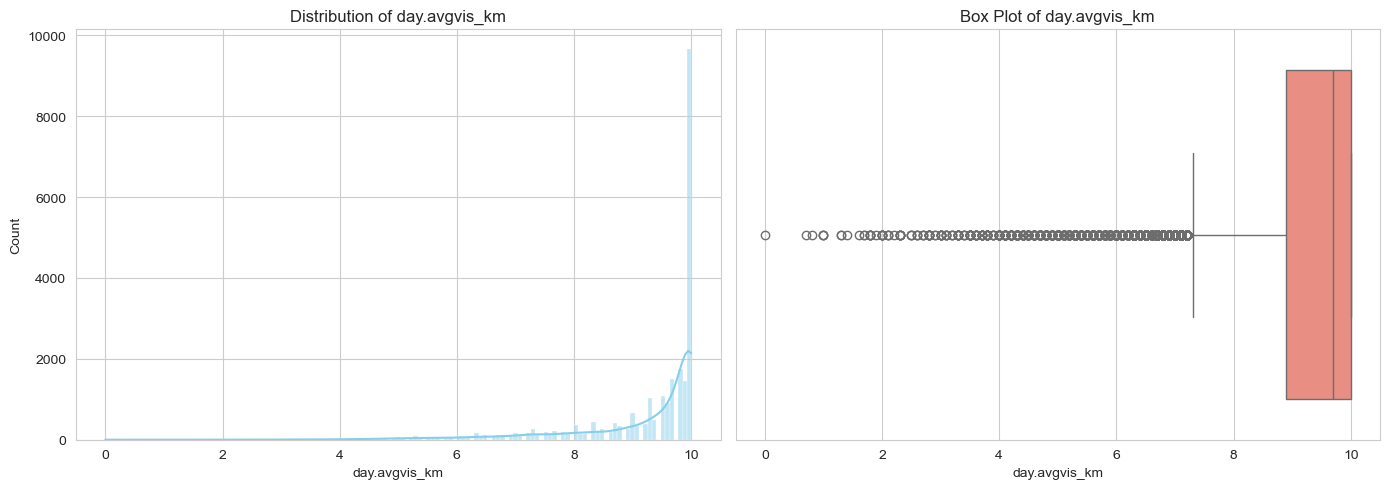



Analysis for: day.avghumidity
Mean: 76.84 | Median: 79.00 | Std: 11.40
Min: 24.00 | Max: 100.00
Skewness: -0.71 (0=Normal, >0=Right Skewed, <0=Left Skewed)
Missing Values: 0.00%
Outliers (IQR method): 395 rows (1.53%)
Reasonable Range (Expected): 47.50 to 107.50


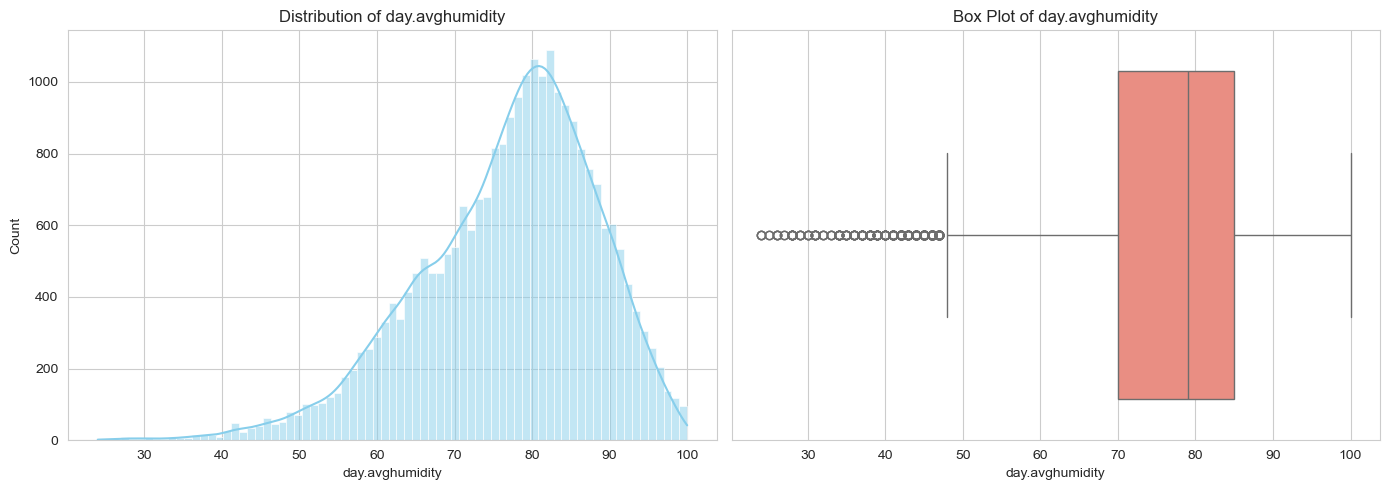



Analysis for: day.uv
Mean: 6.48 | Median: 7.00 | Std: 1.10
Min: 2.00 | Max: 10.00
Skewness: -0.39 (0=Normal, >0=Right Skewed, <0=Left Skewed)
Missing Values: 0.00%
Outliers (IQR method): 1748 rows (6.78%)
Reasonable Range (Expected): 4.50 to 8.50


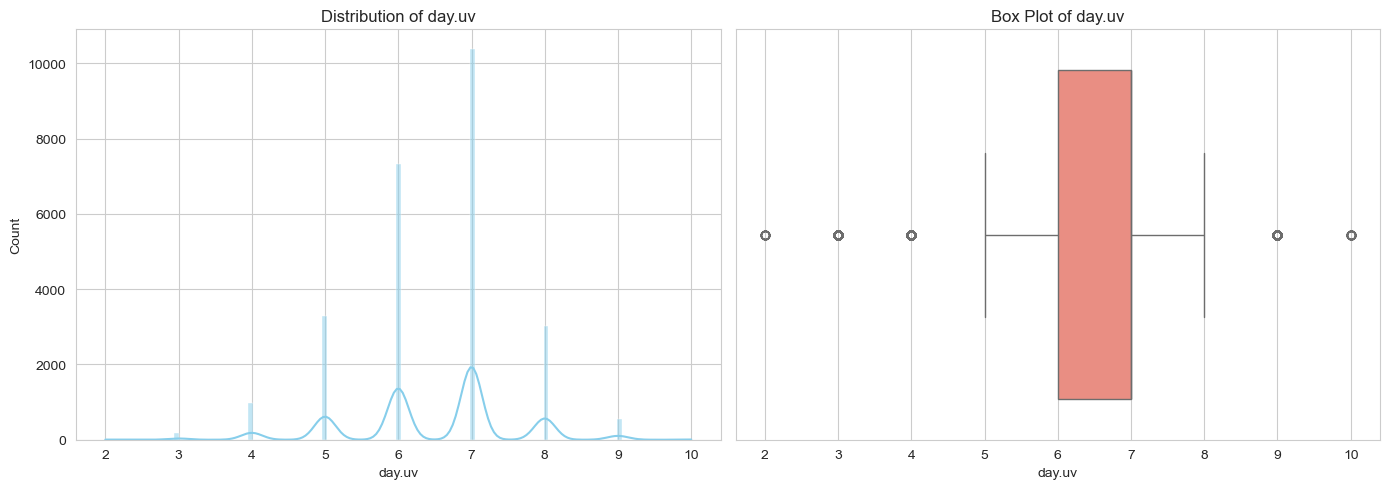

In [48]:
numerical_cols_3 = [
    'day.avgvis_km', 'day.avghumidity', 
    'day.uv'
]

# Execute Analysis
for col in numerical_cols_3:
    analyze_numerical_column(df, col)


## Phân tích chi tiết cho: Tầm nhìn (day.avgvis_km), Độ ẩm (day.avghumidity), và Chỉ số UV (day.uv).
#### 1. Tầm nhìn trung bình (day.avgvis_km)
##### Phân phối (Distribution):

- Hình dạng: Phân phối Lệch trái mạnh (Strongly Left Skewed) với Skewness = -2.15.

- Hiện tượng "Trần dữ liệu" (Ceiling Effect): Biểu đồ Histogram có một cột dựng đứng rất cao ở giá trị cực đại 10.0 km.

**Giải thích: Trong các báo cáo khí tượng, tầm nhìn thường được đo tối đa là 10km (hoặc ghi là "10km+"). Tức là dù trời trong xanh nhìn xa 20km thì dữ liệu vẫn chỉ ghi là 10km. Do đó, phân phối này hoàn toàn bình thường do giới hạn của thiết bị đo/API.**

#### Phạm vi & Giá trị ngoại lai (Outliers):

- Trung bình: 9.17 km (Rất gần với mức tối đa, cho thấy đa số thời gian tầm nhìn ở VN khá tốt).

- Outliers: Có tới 9.35% dữ liệu bị coi là ngoại lai (nằm bên trái biểu đồ Box Plot, dưới 7.25 km).

**Ý nghĩa: Những "outliers" này (tầm nhìn thấp < 5km, thậm chí 0-2km) đại diện cho những ngày có sương mù dày đặc, mưa lớn hoặc ô nhiễm không khí nặng. Đây là những đặc trưng quan trọng cần giữ lại để phân tích chất lượng không khí hoặc an toàn giao thông.**

#### 2. Độ ẩm trung bình (day.avghumidity)
##### Phân phối (Distribution):

- Hình dạng: Phân phối Lệch trái (Left Skewed) với Skewness = -0.71. Đỉnh phân phối lệch về phía các giá trị cao (khoảng 80%).

- Đặc tính khí hậu: Trung vị (Median) là 79%, phản ánh chính xác đặc điểm khí hậu nhiệt đới gió mùa nóng ẩm của Việt Nam.

##### Phạm vi & Giá trị ngoại lai:

- Max (100%): Độ ẩm bão hòa, thường xảy ra vào những ngày mưa dầm hoặc nồm ẩm (đặc biệt ở miền Bắc).

- Min (24%): Độ ẩm rất thấp. Lưu ý: Mặc dù hiếm, nhưng các vùng như Ninh Thuận, Bình Thuận vào mùa khô hoặc những ngày chịu ảnh hưởng của gió Lào (gió Phơn) khô nóng thì độ ẩm xuống dưới 30-40% là có thể xảy ra.

- Outliers: Các chấm tròn bên trái (độ ẩm thấp) được coi là ngoại lai. Tuy nhiên, trong bối cảnh dữ liệu khí tượng, đây là dấu hiệu của các đợt nắng nóng cực đoan/khô hạn.

#### 3. Chỉ số UV (day.uv)
##### Phân phối (Distribution):

- Hình dạng: Biểu đồ Histogram có dạng Đa đỉnh (Multimodal) và bị ngắt quãng (rời rạc). Các cột cao tập trung ở các giá trị nguyên như 5, 6, 7, 8.

**Nhận xét về dữ liệu: Điều này cho thấy nguồn dữ liệu gốc (API) trả về chỉ số UV dưới dạng số nguyên (integer) hoặc làm tròn, thay vì số thực liên tục.**

##### Phạm vi & Giá trị ngoại lai:

- Trung bình: 6.48. Theo thang đo UV, mức 6-7 là mức "Cao" (High). Điều này hợp lý với một quốc gia nằm gần xích đạo và có số giờ nắng cao như VN.

- Max (10.00): Mức "Rất cao" (Very High), gây nguy hại cho da nếu tiếp xúc trực tiếp.

- Outliers: Có khoảng 6.78% dữ liệu là ngoại lai, tập trung ở các giá trị thấp (2, 3). Đây thường là những ngày mưa bão, trời âm u dày đặc mây nên chỉ số UV thấp.

### Tổng kết chung
Sau khi phân tích toàn bộ các biến số (Nhiệt, Mưa, Gió, Độ ẩm, UV, Tầm nhìn), chúng ta có bức tranh tổng thể:

**Mối tương quan tiềm năng (Correlations):**

- day.avgvis_km thấp (tầm nhìn kém) khả năng cao sẽ tương quan mạnh với day.avghumidity cao (sương mù) hoặc day.totalprecip_mm cao (mưa to).

- day.uv cao (nắng to) sẽ tương quan nghịch với day.avghumidity và day.totalprecip_mm.

- Độ sạch của dữ liệu: Dữ liệu số học cực kỳ sạch sẽ, không có giá trị rác (như số âm cho lượng mưa hay độ ẩm >100%).

**Khi Feature Engineering:**

- Biến day.avgvis_km: Do bị chặn trần ở 10km, biến này có thể ít nhạy (less sensitive) trong việc phân biệt các ngày "trời đẹp". Nó sẽ hữu ích hơn trong việc phát hiện "thời tiết xấu".

- Biến day.uv: Do dữ liệu có tính rời rạc (làm tròn số), nó có thể hoạt động tốt nếu được chuyển đổi thành biến phân loại (Ordinal Category) như: Thấp, Trung bình, Cao, Cực cao thay vì để dạng số thực.

## Categorical Columns Analysis

Analysis for: location.name
Unique Values: 63
Missing Values: 0.00%
Top 10 Most Frequent Values:
location.name
An Giang      409
Thái Bình     409
Ninh Bình     409
Ninh Thuận    409
Phú Thọ       409
Phú Yên       409
Quảng Bình    409
Quảng Nam     409
Quảng Ngãi    409
Quảng Ninh    409
Name: count, dtype: int64
Imbalance Ratio (Max/Min count): 1.00 (1.0 = Perfectly Balanced)


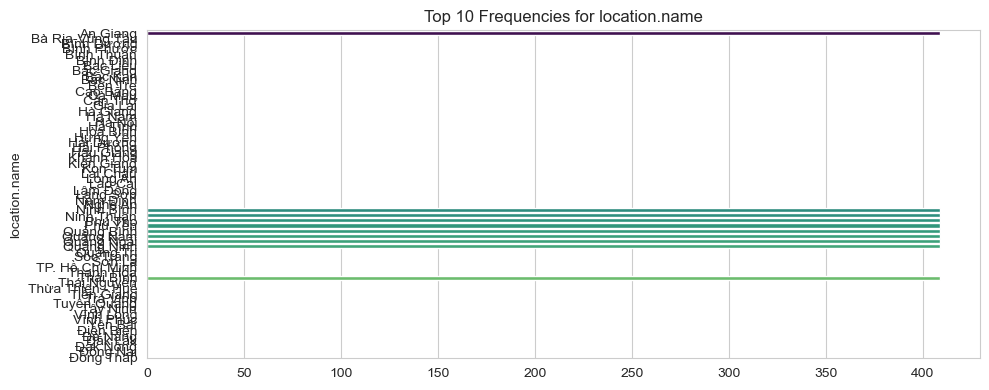



Analysis for: location.region
Unique Values: 7
Missing Values: 0.00%
Top 10 Most Frequent Values:
location.region
Bắc Trung Bộ và Duyên hải miền Trung    5726
Trung du và miền núi Bắc Bộ             5317
Đồng Bằng Sông Cửu Long                 5317
Đồng Bằng Sông Hồng                     4498
Đông Nam Bộ                             2454
Tây Nguyên                              2045
Tr [*]ung du và miền núi Bắc Bộ          409
Name: count, dtype: int64
Imbalance Ratio (Max/Min count): 14.00 (1.0 = Perfectly Balanced)


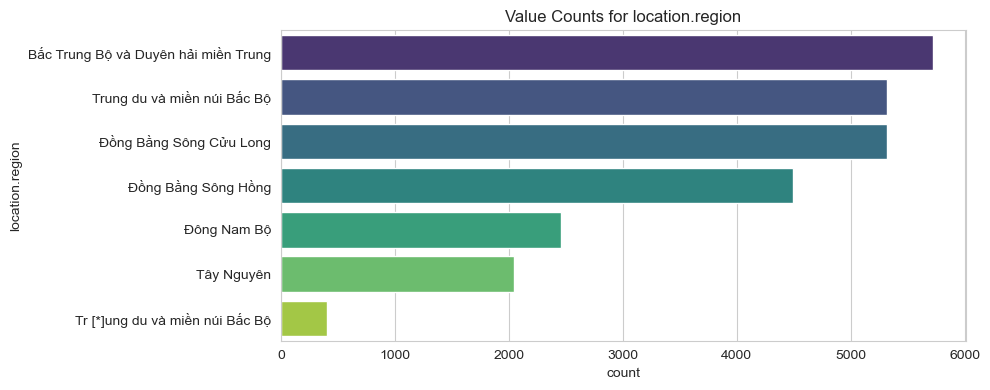

All Unique Categories: ['Bắc Trung Bộ và Duyên hải miền Trung', 'Tr [*]ung du và miền núi Bắc Bộ', 'Trung du và miền núi Bắc Bộ', 'Tây Nguyên', 'Đông Nam Bộ', 'Đồng Bằng Sông Cửu Long', 'Đồng Bằng Sông Hồng']


Analysis for: day.daily_will_it_rain
Unique Values: 2
Missing Values: 0.00%
Top 10 Most Frequent Values:
day.daily_will_it_rain
True     19088
False     6678
Name: count, dtype: int64
Imbalance Ratio (Max/Min count): 2.86 (1.0 = Perfectly Balanced)


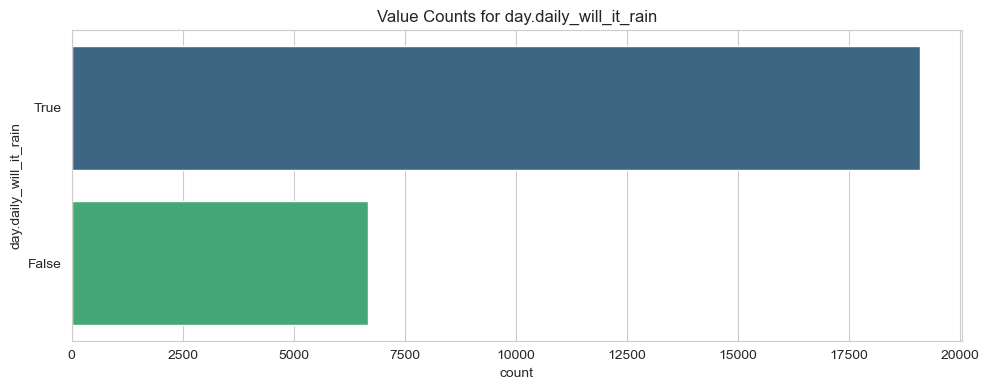

In [49]:
def analyze_categorical_column(df, col):
    print(f"Analysis for: {col}")
    
    # 1. Value Distribution Stats
    unique_count = df[col].nunique()
    missing_pct = df[col].isnull().mean() * 100
    
    print(f"Unique Values: {unique_count}")
    print(f"Missing Values: {missing_pct:.2f}%")
    
    # Top Frequent Values
    top_counts = df[col].value_counts().head(10)
    print("Top 10 Most Frequent Values:")
    print(top_counts)
    
    # Balance Check (Ratio of Top to Bottom frequency)
    if unique_count > 1:
        balance_ratio = df[col].value_counts().max() / df[col].value_counts().min()
        print(f"Imbalance Ratio (Max/Min count): {balance_ratio:.2f} (1.0 = Perfectly Balanced)")
    
    # 2. Visualizations
    plt.figure(figsize=(10, 4))
    
    if unique_count > 20:
        # If too many categories, plot only top 20
        sns.barplot(x=top_counts.values, y=top_counts.index, palette='viridis')
        plt.title(f'Top 10 Frequencies for {col}')
    else:
        sns.countplot(data=df, y=col, order=df[col].value_counts().index, palette='viridis')
        plt.title(f'Value Counts for {col}')
        
    plt.tight_layout()
    plt.show()
    
    # 3. Inconsistency Check (Quick heuristic for text columns)
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        # Check for similar strings that might be typos (e.g., "Hanoi" vs "Ha Noi" - basic check)
        # This just prints the raw unique values sorted to spot duplicates visually
        unique_vals = sorted(df[col].dropna().unique().astype(str))
        if len(unique_vals) < 50:
            print(f"All Unique Categories: {unique_vals}")
    
    print("\n" + "="*80 + "\n")

# Define Categorical Columns based on previous steps
categorical_cols = [
    'location.name', 'location.region'
]
# Note: 'day.daily_will_it_rain' is boolean but acts like categorical
categorical_cols.append('day.daily_will_it_rain')

# Execute Analysis
for col in categorical_cols:
    if col in df.columns:
        analyze_categorical_column(df, col)

Dữ liệu cho thấy sự cân bằng tuyệt đối: mỗi tỉnh thành trong số 63 tỉnh của Việt Nam đều có chính xác 409 dòng dữ liệu.

- Không có "Top" thực sự: Khi tất cả 63 tỉnh đều có số lượng bằng nhau, khái niệm "Top 10 xuất hiện nhiều nhất" trở nên vô nghĩa (vì ai cũng là hạng nhất).

- Vấn đề hiển thị: Do tất cả đều bằng nhau, biểu đồ cố gắng hiển thị danh sách (có thể là theo thứ tự bảng chữ cái), làm cho các nhãn tên tỉnh bị chồng chéo lên nhau nếu khung hình không đủ lớn.

**Ý nghĩa con số 409:** đại diện cho số ngày thu thập dữ liệu.

=> Điều này xác nhận rằng quy trình thu thập dữ liệu (Data Collection) đã hoạt động hoàn hảo: Không có tỉnh nào bị mất ngày nào so với tỉnh khác. Dữ liệu đồng bộ trên toàn quốc từ ngày đầu đến ngày cuối.

**Kết luận cho cột này:**

- Dữ liệu Sạch 100%: Không cần xử lý mất cân bằng (imbalanced data).

- Hành động: Chúng ta không cần làm gì thêm với cột này về mặt làm sạch.

Analysis for: location.terrain
Unique Values: 3
Missing Values: 0.00%
Top 10 Most Frequent Values:
location.terrain
ven biển     10633
miền núi      8180
đồng bằng     6953
Name: count, dtype: int64
Imbalance Ratio (Max/Min count): 1.53 (1.0 = Perfectly Balanced)


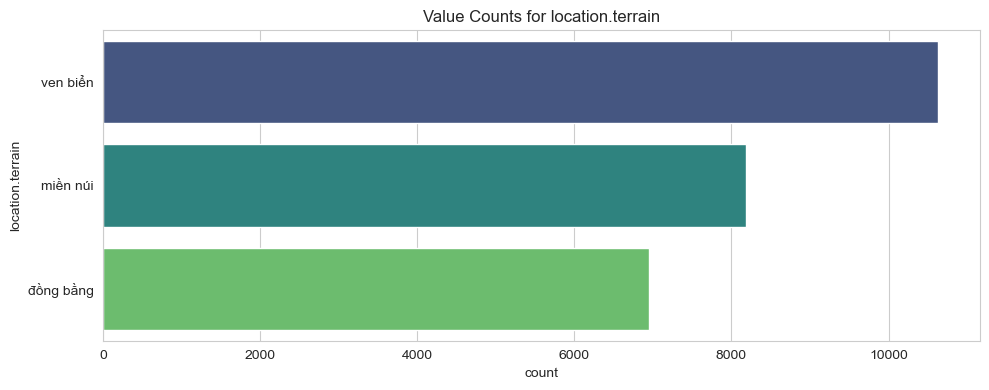

All Unique Categories: ['miền núi', 'ven biển', 'đồng bằng']


Analysis for: day.condition.text
Unique Values: 22
Missing Values: 0.00%
Top 10 Most Frequent Values:
day.condition.text
Moderate or heavy rain shower     7280
Patchy rain possible              6061
Overcast                          2639
Moderate rain at times            2069
Partly cloudy                     1969
Sunny                             1516
Heavy rain at times               1434
Cloudy                            1212
Light rain shower                  976
Patchy light rain with thunder     189
Name: count, dtype: int64
Imbalance Ratio (Max/Min count): 7280.00 (1.0 = Perfectly Balanced)


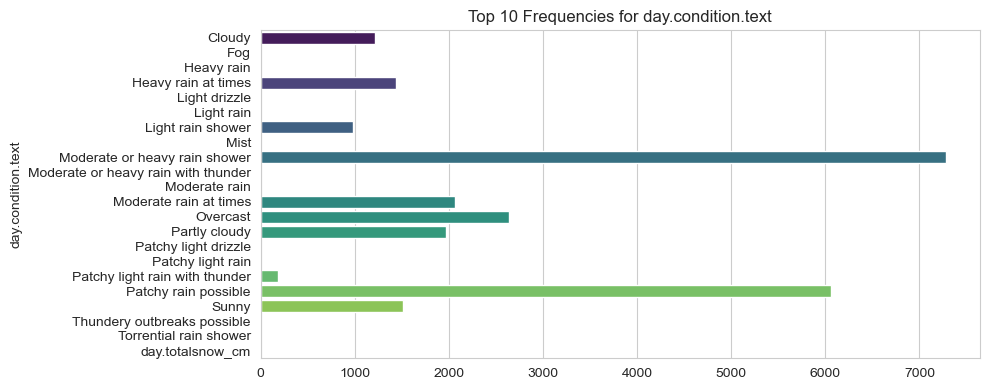

All Unique Categories: ['Cloudy', 'Fog', 'Heavy rain', 'Heavy rain at times', 'Light drizzle', 'Light rain', 'Light rain shower', 'Mist', 'Moderate or heavy rain shower', 'Moderate or heavy rain with thunder', 'Moderate rain', 'Moderate rain at times', 'Overcast', 'Partly cloudy', 'Patchy light drizzle', 'Patchy light rain', 'Patchy light rain with thunder', 'Patchy rain possible', 'Sunny', 'Thundery outbreaks possible', 'Torrential rain shower', 'day.totalsnow_cm']


Analysis for: day.condition.code
Unique Values: 21
Missing Values: 0.00%
Top 10 Most Frequent Values:
day.condition.code
1243    7280
1063    6062
1009    2639
1186    2069
1003    1969
1000    1516
1192    1434
1006    1212
1240     976
1273     189
Name: count, dtype: int64
Imbalance Ratio (Max/Min count): 7280.00 (1.0 = Perfectly Balanced)


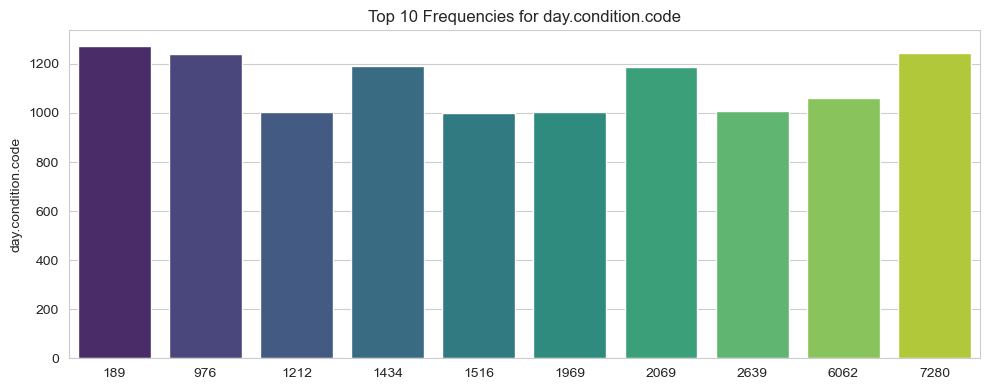

In [50]:
# Define Categorical Columns based on previous steps
categorical_cols_2 = [
    'location.terrain', 
    'day.condition.text', 'day.condition.code'
]

# Execute Analysis
for col in categorical_cols_2:
    if col in df.columns:
        analyze_categorical_column(df, col)

#### 1. Phân tích Biến Phân loại: Địa hình (location.terrain)

##### Phân phối giá trị (Value Distribution):

- Ven biển: 10,633 dòng (Chiếm tỷ trọng cao nhất).

- Miền núi: 8,180 dòng.

- Đồng bằng: 6,953 dòng.

**Nhận xét:**

Tính cân bằng: Tỷ lệ mất cân bằng (Imbalance Ratio) là 1.53. Đây là một tỷ lệ rất tốt (gần 1). Dữ liệu phân bố khá đều giữa 3 loại địa hình, phản ánh đúng đặc thù địa lý của Việt Nam (bờ biển dài, nhiều đồi núi).

Ý nghĩa xây mô hình: Không cần kỹ thuật cân bằng dữ liệu (như SMOTE). Biến này rất tốt để so sánh sự khác biệt khí hậu (ví dụ: So sánh gió ở "Ven biển" vs "Miền núi").

#### 2. Phân tích Biến Phân loại: Kiểu thời tiết (day.condition.text)

- Sự đa dạng: Có 21 kiểu thời tiết khác nhau (Unique values).

##### Top các kiểu thời tiết phổ biến nhất:

- Moderate or heavy rain shower (Mưa rào vừa hoặc to): 7,280 lần (Cao vượt trội).

- Patchy rain possible (Có thể có mưa rải rác): 6,062 lần.

- Overcast (U ám): 2,639 lần.

...

- Sunny (Nắng): Chỉ đứng thứ 6 với 1,516 lần.

#### Vấn đề & Giải pháp:

- Quá chi tiết (Too Granular): Có quá nhiều loại "Mưa" (Mưa rào, mưa lất phất, mưa to, mưa kèm sấm...). Điều này làm **loãng dữ liệu**.

Ta nên **gom nhóm** các giá trị này lại để mô hình dễ học hơn. 3 nhóm:

- Nhóm 1 (Mưa): Moderate rain, Light rain, Heavy rain... -> Gộp thành "Rain".

- Nhóm 2 (Mây/Âm u): Overcast, Cloudy, Partly cloudy -> Gộp thành "Cloudy".

- Nhóm 3 (Nắng/Đẹp): Sunny -> "Clear/Sunny".

#### Kết luận & Bước tiếp theo
- Xử lý day.condition.text: Đây là việc quan trọng nhất. Cần viết hàm để gom 21 loại thời tiết về 3-4 nhóm chính (Mưa, Mây, Nắng).

##### Feature Engineering:

- Tạo cột **is_rainy** (Có mưa không?) từ **day.totalprecip_mm**.

- Tạo cột **season** (Mùa) từ cột date để phân tích sự khác biệt khí hậu theo mùa.

## Missing Data Analysis


MISSING VALUES SUMMARY:
------------------------------------------------------------
Tuyệt vời! Bộ dữ liệu không có bất kỳ giá trị bị thiếu nào (0 missing values).
------------------------------------------------------------
                 Column Name  Missing Count  Percentage (%)
0              location.name              0             0.0
1            location.region              0             0.0
2           location.terrain              0             0.0
3               location.lat              0             0.0
4               location.lon              0             0.0
5                       date              0             0.0
6              day.maxtemp_c              0             0.0
7              day.mintemp_c              0             0.0
8              day.avgtemp_c              0             0.0
9            day.maxwind_kph              0             0.0
10        day.totalprecip_mm              0             0.0
11             day.avgvis_km              0            

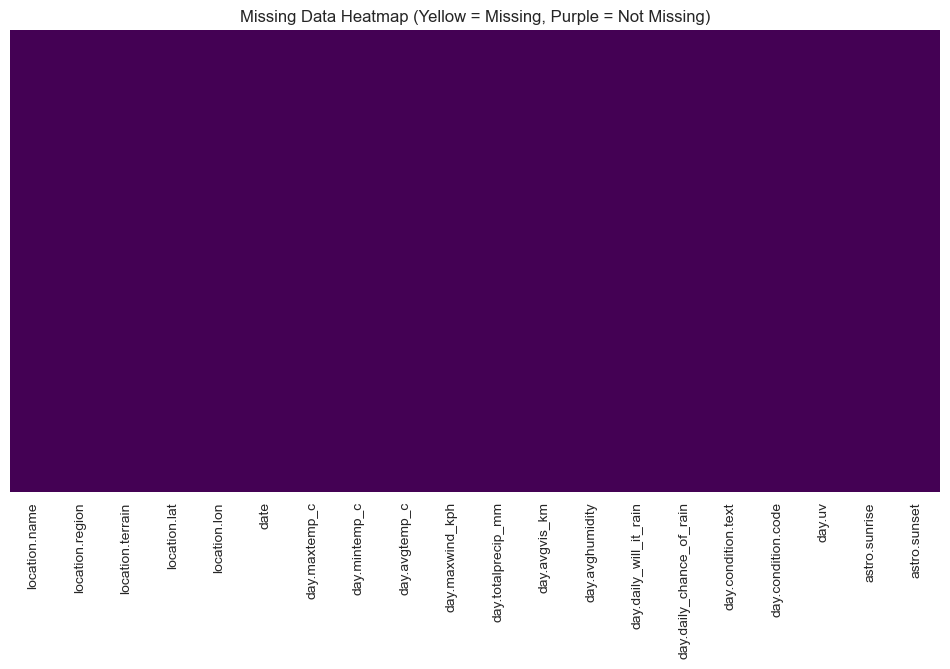

In [51]:
# --- 3. Missing Data Analysis ---

# 1. Create a missing values summary
missing_data = df.isnull().sum().reset_index()
missing_data.columns = ['Column Name', 'Missing Count']
missing_data['Percentage (%)'] = (missing_data['Missing Count'] / len(df)) * 100

# Lọc ra các cột có dữ liệu thiếu (nếu có) để hiển thị, hoặc hiển thị top 5 nếu tất cả đều bằng 0
print("MISSING VALUES SUMMARY:")
print("-" * 60)
if missing_data['Missing Count'].sum() == 0:
    print("Tuyệt vời! Bộ dữ liệu không có bất kỳ giá trị bị thiếu nào (0 missing values).")
    print("-" * 60)
    print(missing_data)
else:
    print(missing_data[missing_data['Missing Count'] > 0])

# 2. Visualize missing data patterns
# Vì dữ liệu có thể không có missing, ta vẽ heatmap để chứng minh sự "sạch sẽ" của nó
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data Heatmap (Yellow = Missing, Purple = Not Missing)')
plt.show()

# (Tùy chọn) Biểu đồ cột nếu có dữ liệu thiếu
if missing_data['Missing Count'].sum() > 0:
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Percentage (%)', y='Column Name', data=missing_data[missing_data['Missing Count'] > 0], palette='Reds_r')
    plt.title('Percentage of Missing Values per Column')
    plt.show()

**Overall Assessment:**

Dựa trên biểu đồ Heatmap và bảng thống kê, bộ dữ liệu hoàn toàn sạch sẽ. Màu tím đồng nhất trên Heatmap cho thấy không có bất kỳ khoảng trống dữ liệu nào.

Không xác định được giá trị thiếu có ngẫu nhiên hay theo quy luật nào hay không vì không có giá trị bị thiếu.

**Per Column Strategy:**
*   **Observation:** Tất cả các cột đều có `Missing Count = 0` (0%).
*   **Reason:** Quy trình thu thập dữ liệu (Data Collection) qua API đã được thực hiện trọn vẹn, hoặc dữ liệu nguồn đã được xử lý trước khi tải lên Kaggle.
*   **Plan:** Không cần thực hiện các kỹ thuật xử lý dữ liệu thiếu (như Imputation hay Dropping rows). Dữ liệu đã sẵn sàng cho các bước phân tích tiếp theo.

### Cơ Chế Xử Lý Giá Trị Thiếu Nếu Có Trong Tương Lai

Mặc dù bộ dữ liệu hiện tại hoàn toàn đầy đủ (**0 missing values**), nhưng trong thực tế, dữ liệu thu thập trong tương lai (từ API hoặc các nguồn khác) có thể gặp lỗi đường truyền hoặc thiếu sót dẫn đến tồn tại giá trị bị thiếu.

Để đảm bảo tính bền vững cho quy trình xử lý dữ liệu (pipeline), tôi thiết lập sẵn một hệ thống xử lý tự động với chiến lược khác nhau cho từng loại dữ liệu.

#### **Per-Column Strategy**
**Lý do lựa chọn thuật toán:**

**1. DateTime Columns → Forward Fill + Backward Fill**
   - **Nguyên nhân thiếu tiềm tàng:** Lỗi ghi nhận timestamp, mất đồng bộ thời gian hệ thống
   - **Chiến lược:** Forward Fill (ffill) kết hợp Backward Fill (bfill) dự phòng
   - **Lý do:** 
     * Dữ liệu thời gian có tính liên tục và tuần tự
     * Nếu thiếu ngày 15/12, ta giả định nó gần với ngày 14/12 (forward fill)
     * Nếu dòng đầu tiên thiếu (không có giá trị trước đó), dùng backward fill lấy từ dòng tiếp theo
   - **Công cụ:** `df[col].ffill()` và `df[col].bfill()`

**2. Categorical Columns → Mode Imputation**
   - **Nguyên nhân thiếu tiềm tàng:** Lỗi API, dữ liệu không áp dụng (N/A), lỗi mã hóa text
   - **Chiến lược:** Điền bằng giá trị xuất hiện nhiều nhất (Most Frequent / Mode)
   - **Lý do:** 
     * Không thể tính trung bình cho dữ liệu dạng text/category
     * Giá trị phổ biến nhất phản ánh xu hướng chung của dữ liệu
   - **Công cụ:** `SimpleImputer(strategy='most_frequent')`

**3. Numerical Columns → MICE với Decision Tree**
   - **Nguyên nhân thiếu tiềm tàng:** Lỗi cảm biến, mất tín hiệu, sự cố thiết bị đo đạc
   - **Chiến lược:** Model-Based Imputation sử dụng MICE (Multiple Imputation by Chained Equations)
   - **Lý do:** 
     * Dữ liệu thời tiết có mối quan hệ phi tuyến tính phức tạp:
       - Nhiệt độ cao + Độ ẩm thấp → Khả năng mưa thấp
       - Áp suất giảm + Tốc độ gió tăng → Khả năng có bão
       - Độ ẩm cao + Nhiệt độ thấp → Có thể xuất hiện sương mù
     * `DecisionTreeRegressor` nắm bắt các mẫu hình phi tuyến này tốt hơn hồi quy tuyến tính đơn thuần
     * `IterativeImputer` (MICE) sử dụng thông tin từ **tất cả** các cột số khác để dự đoán giá trị thiếu một cách chính xác qua nhiều vòng lặp (max_iter=10)
   - **Công cụ:** `IterativeImputer(estimator=DecisionTreeRegressor())`

#### **Plan:**

**Bước 1: Phát hiện và Phân loại**
- Quét toàn bộ DataFrame để phát hiện missing values
- Xác định loại dữ liệu của từng cột (datetime, categorical, numerical)
- Lọc ra các cột thực sự bị thiếu để tối ưu hiệu suất

**Bước 2: Áp Dụng Chiến Lược Tương Ứng**
- **Nếu datetime** → Forward Fill (ffill) → Nếu vẫn còn thiếu → Backward Fill (bfill)
- **Nếu categorical** → SimpleImputer với strategy='most_frequent'
- **Nếu numerical** → IterativeImputer (MICE + DecisionTreeRegressor)

**Bước 3: Kiểm Tra và Xác Nhận**
- Kiểm tra lại toàn bộ DataFrame
- Đảm bảo `remaining_missing = 0`
- Xác nhận các kiểu dữ liệu không bị thay đổi (đặc biệt là category type)


In [52]:

from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor

print("PREDICTOR MODEL")

# Kiểm tra tổng số lượng giá trị thiếu trong toàn bộ DataFrame
total_missing = df.isnull().sum().sum()

if total_missing > 0:
    print(f"Phát hiện {total_missing} giá trị bị thiếu. Đang tiến hành dự đoán và điền dữ liệu...")

    # Xử lý cột datetime
    # Chiến lược: Forward Fill (lấy ngày hôm trước điền cho ngày hôm sau)
    # Lý do: Thời gian thường liên tục, nếu thiếu thì khả năng cao là ngày kế tiếp.
    datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
    
    # Chỉ xử lý cột có missing
    datetime_cols_missing = [col for col in datetime_cols if df[col].isnull().sum() > 0]

    if len(datetime_cols_missing) > 0:
        print(f"Đang xử lý cột thời gian (Forward Fill): {datetime_cols_missing}")
        for col in datetime_cols_missing:
            df[col] = df[col].ffill()
            
            # Nếu dòng đầu tiên bị thiếu (không có ngày trước đó), dùng bfill (Back Fill)
            if df[col].isnull().sum() > 0:
                 df[col] = df[col].bfill()


    # Xử lý các cột Phân loại (Categorical/Object/Boolean)
    # Chiến lược: Điền bằng giá trị xuất hiện nhiều nhất (Most Frequent / Mode)
    # Lý do: Không thể tính trung bình cộng cho chữ, nên ta chọn giá trị phổ biến nhất.
    cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns
    
    # Chỉ xử lý các cột thực sự bị thiếu
    cat_cols_missing = [col for col in cat_cols if df[col].isnull().sum() > 0]
    
    if len(cat_cols_missing) > 0:
        print(f"Đang điền dữ liệu thiếu cho các cột phân loại (Mode): {cat_cols_missing}")
        cat_imputer = SimpleImputer(strategy='most_frequent')
        
        # Fit và Transform
        df[cat_cols_missing] = cat_imputer.fit_transform(df[cat_cols_missing])
        
        # SimpleImputer có thể làm mất kiểu 'category', convert lại nếu cần
        for col in cat_cols_missing:
             if df[col].dtype == 'object':
                df[col] = df[col].astype('category')
    # Xử lý cột số
    # Chiến lược: Model-based Imputation (Decision Tree)
    # IterativeImputer chỉ hoạt động trên các con số, không chạy được trên text/category
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    print(f"Các cột được sử dụng để tính toán: {list(numeric_cols)}")

    # Khởi tạo Imputer
    # Sử dụng DecisionTreeRegressor vì nó nắm bắt tốt các mối quan hệ phi tuyến tính trong thời tiết
    imputer = IterativeImputer(
        estimator=DecisionTreeRegressor(random_state=42),
        max_iter=10,
        random_state=42
    )

    # Fit và Transform (Học từ dữ liệu có sẵn -> Điền vào chỗ trống)
    # Chỉ áp dụng trên các cột số
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

    print("Đã hoàn tất việc điền giá trị thiếu (Imputation Complete).")
    
    # Kiểm tra lại lần cuối
    remaining_missing = df.isnull().sum().sum()
    print(f"Số lượng giá trị thiếu còn lại: {remaining_missing}")

else:
    print("Dữ liệu hiện tại đầy đủ (0 missing values).")
    print("Bỏ qua bước Model-based Imputation.")

PREDICTOR MODEL
Dữ liệu hiện tại đầy đủ (0 missing values).
Bỏ qua bước Model-based Imputation.
